# Binary text classification
2022 COMP5046 Assignment 1 - 
*Make sure you change the file name with your unikey.*

# Readme

💎 Please **run all OOP section first** and then main section.💎   
💎 U can do it by click run after for the first cell in OOP:) 💎 

- All detailed implmentation is written at the **OOP** section at the bottom. 

- Add best model result at section 4.4, which is loaded from gdrive.    

- I added batch size to training and better preprocessing after I finished all the evaluation, it turns out I then need to rewrite everything, so the evalution is based on the no batch version but the coding part has changed to the one using batch. 

***Visualising the comparison of different results is a good way to justify your decision.***

# 1 - Data Preprocessing

## 1.0. Data Collection [DO NOT MODIFY THIS]

In [22]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '16g474hdNsaNx0_SnoKuqj2BuwSEGdnbt'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('training_data.csv')  

id = '1-7hj0sF3Rc5G6POKdkpbDXm_Q6BWFDPU'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('testing_data.csv')  

import pandas as pd
training_data = pd.read_csv("/content/training_data.csv")
testing_data = pd.read_csv("/content/testing_data.csv")

print("------------------------------------")
print("Size of training dataset: {0}".format(len(training_data)))
print("Size of testing dataset: {0}".format(len(testing_data)))
print("------------------------------------")

print("------------------------------------")
print("Sample Data")
print("LABEL: {0} / SENTENCE: {1}".format(training_data.iloc[-1,0], training_data.iloc[-1,1]))
print("------------------------------------")


------------------------------------
Size of training dataset: 7808
Size of testing dataset: 867
------------------------------------
------------------------------------
Sample Data
LABEL: F / SENTENCE: 'Half of it is going straight to charity, another quarter going straight to scientific research, an eighth to the parkour community, a sixteenth to towards spreading information about health and...|||Find a path or suffer more.|||http://personalitycafe.com/enneagram-personality-theory-forum/85323-enneagram-type-mbti-type-compared-statistics.html yep.|||I kind of anchor on Fi and Ne makes having Ni really fun. INFP for me as they tire me out less and our views tend to align more.|||The two ESTPs I have gotten the chance to know seem to experience much more than other people who have been on the planet for the same amount of time and are quite the renaissance (wo)men.  Is this...|||I don't really have a best friend ISTP(passion-amateur group co-founder), INTJ(intellectual and various sma

In [23]:
# Preview of the data in the csv file, which has two columns: 
# (1)type - label of the post (2)posts - the corresponding post content
training_data.head()

,type,posts
0,F,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,T,'I'm finding the lack of me in these posts ver...
2,T,'Good one _____ https://www.youtube.com/wat...
3,T,"'Dear INTP, I enjoyed our conversation the o..."
4,T,'You're fired.|||That's another silly misconce...


In [24]:
# Extract the labels and posts and store into List

# Get the list of training data (posts)
training_posts=training_data['posts'].tolist()
# Get the list of corresponding labels for the training data (posts)
training_labels=training_data['type'].tolist()

# Get the list of testing data (posts)
testing_posts=testing_data['posts'].tolist()
# Get the list of corresponding labels for the testing data (posts)
testing_labels=testing_data['type'].tolist()

## 1.1. URL Removal
*related to the section 4.2*

In [25]:
# Better naming
X_train = training_posts
X_test = testing_posts
y_train = training_labels
y_test = testing_labels

# REmove the URL for both training and testing set
X_train_no_url = Prep.url_removal(X_train)
X_test_no_url = Prep.url_removal(X_test)

## 1.2. Preprocess data (e.g. Stop words, Stemming)
*related to the section 4.2*

In [26]:
# 2 mins+
# The best one
X_train_best = Prep.pre_processing(X_train) # 15mins+ -> 4 mins after use only english stopwords -> 2mins30s: after remove stemming and lemm -> 1min : take firs 512 tokens
X_test_best= Prep.pre_processing(X_test) 

word_list, vocab = Emb.build_vocab(X_train_best)
# Encode input 
X_train_encoded = Prep.encode_and_add_padding(X_train_best, vocab)
X_test_encoded = Prep.encode_and_add_padding(X_test_best, vocab)
y_train_encoded = Prep.encode_label(y_train)
y_test_encoded = Prep.encode_label(y_test)

# 💎Uncomment below to load the preprocess data from gdrive instead of real time processing since too long.
# h.download_best_model_gdrive()
# with open('X_train_number.json','r') as f:
#     X_train_processed_number = json.load(f)['data']

# 2 - Input Representation


## 2.1. Word Embedding Construction
*related to the section 4.1 and 4.3*


In [27]:
# 2mins
# 💎 Preprocess data for word embeddings
# use both the training and testing datasets
X_train_embed= X_train_best + X_test_best

# 💎 Build the best self train model - FastText
model_word2vec = Emb.make_self_trained_gensim_model(X_train_embed, dimension_=150, window_=3) # 5min+

emb_table_word2vec, emb_dim_word2vec = Emb.build_concat_embed_table(word_list, [model_word2vec])

## 2.2. Pretrained Word Embedding
*related to the section 4.3*

In [28]:
# 2mins+
# load pretrain twitter-25
model_twitter = Emb.load_pre_train_gensim(which_=1)

# Extract and apply the embedding
# Note it is applied as this embedding is concatenated in 2.3 which is then trained in 3.2 and evaluated in 4.3
emb_table_twitter, emb_dim_twitter = Emb.build_concat_embed_table(word_list, [model_twitter])

# load pretrain wiki-100
model_wiki = Emb.load_pre_train_gensim(which_=2)

# Extract and apply the embedding 
emb_table_wiki, emb_dim_wiki = Emb.build_concat_embed_table(word_list, [model_wiki])

[==================================================] 100.0% 104.8/104.8MB downloaded
[==================================================] 100.0% 128.1/128.1MB downloaded


## 2.3. Input Concatenation
*related to the section 4.3*

In [41]:
# Best Concatenation pretrain twitter & wiki
emb_table_concat, emb_dim_concat = Emb.build_concat_embed_table(word_list, [model_twitter, model_wiki]) 

# Below is the concatenation for self train + pretrained
# emb_table_concat, emb_dim_concat = Emb.build_concat_embed_table(word_list, [model_word2vec, model_twitter, model_wiki]) 

# To address the OOV issue, the embedding is extracted the word exists in both the self train and pretrained
# Otherwise, it is pad with 0s.

# 3 - Model Implementation

## 3.1. Build Sequence Model (Bi-directional model)
*related to the section 4.4*

In [44]:
class Bi_LSTM_Emb(nn.Module):
    """
    This Bi-LSTM model use the weights from the pretrained word embedding as shown in below: data.copy_
    """
    def __init__(self, vocab_size, n_hidden, n_class, emb_dim, emb_table):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        # [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        # Optional: set requires_grad = False to make this lookup table untrainable
        self.emb.weight.requires_grad = False

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)
        
    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        # we will use the returned h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        # details of the outputs from nn.LSTM can be found from: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        # c_n: containing the final cell state for each element in the sequence.
        _, (h_n, c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z

## 3.2. Train Sequence Model (Bi-directional model)

*related to the section 4.4*

Note that it will not be marked if you do not display the Training Loss and the Number of Epochs in the Assignment 1 ipynb.


In [70]:
# Define best sequence model params
PARAMS = {
    'vocab_size': len(word_list),
    'n_class': 2,
    'n_hidden': 32,
    'lr': 1e-3, # learning rate 
    'n_epoch': 250
}

model_eval, val_history = Train.train_sequence_model(X_train_encoded, y_train_encoded, PARAMS, emb_dim_concat, emb_table_concat, test_data=[X_test_encoded, y_test_encoded])
# dropout give 0.6 poor result

Epoch: 1, loss: 0.72880, train_acc: 0.45
Epoch: 2, loss: 0.68969, train_acc: 0.55
Epoch: 3, loss: 0.71804, train_acc: 0.42
Epoch: 4, loss: 0.69931, train_acc: 0.39
Epoch: 5, loss: 0.68372, train_acc: 0.58
Epoch: 6, loss: 0.69651, train_acc: 0.50
Epoch: 7, loss: 0.67035, train_acc: 0.67
Epoch: 8, loss: 0.73025, train_acc: 0.42
Epoch: 9, loss: 0.70207, train_acc: 0.50
Epoch: 10, loss: 0.70532, train_acc: 0.50
Epoch: 11, loss: 0.65637, train_acc: 0.66
Epoch: 12, loss: 0.69071, train_acc: 0.58
Epoch: 13, loss: 0.64800, train_acc: 0.69
Epoch: 14, loss: 0.69779, train_acc: 0.55
Epoch: 15, loss: 0.71276, train_acc: 0.52
Epoch: 16, loss: 0.66253, train_acc: 0.62
Epoch: 17, loss: 0.67896, train_acc: 0.62
Epoch: 18, loss: 0.69338, train_acc: 0.52
Epoch: 19, loss: 0.66535, train_acc: 0.62
Epoch: 20, loss: 0.70982, train_acc: 0.45
Epoch: 21, loss: 0.71053, train_acc: 0.52
Epoch: 22, loss: 0.70706, train_acc: 0.47
Epoch: 23, loss: 0.67143, train_acc: 0.59
Epoch: 24, loss: 0.65034, train_acc: 0.69
E

# 4 - Evaluation


## 4.1. Word Embedding Evaluation
You are to apply Semantic-Syntactic word relationship tests for the trained word embeddings and visualise the result of Semantic-Syntactic word relationship tests.
Note that it will not be marked if you do not display it in the ipynb file.


(*Please show your empirical evidence and justification*)

🎶 **Table**

Different feature **dimension** :    

| Dim | Window Size |Sem |Syn |Tot. |
| --- | --- | --- | --- | --- |
| 100  | 5 | 12.75%  (38/298) | 48.41%  (990/2045) | 43.88%  (1028/2343) |
| 150 | 5 | 12.42%  (37/298) | 50.86%  (1040/2045) | 45.97%  (1077/2343) |
| 200 | 5 | 8.72%  (26/298) | 51.39%  (1051/2045) | 45.97%  (1077/2343) |

---
Different **window size**:    

| Dim | Window Size |Sem |Syn |Tot. |
| --- | --- | --- | --- | --- |
| 150 | 3 | 10.74%  (32/298) | 55.31%  (1131/2045) | 49.64%  (1163/2343) |
| 150 | 5 | 12.42%  (37/298) | 50.86%  (1040/2045) | 45.97%  (1077/2343) |
| 150 | 7 | 14.77%  (44/298) | 47.33%  (968/2045) | 43.19%  (1012/2343) |
| 150 | 10 | 15.44%  (46/298) | 42.25%  (864/2045) | 38.84%  (910/2343) |
 
🎈 Model used: FastText & skipgram - self train gensim   


🍔 **1. Observation & Explain the pattern**

💎 **1.1 Window size**

As seem from above table and below chart:  
- (1) the semantic accuracy goes up as the window size increases while
- (2) the syntactic and overall accuracy goes down.

(1) is because:
- **Context** of a word is defined by its **surrounding** words
- As the window size goes large, more words are used to be trained for the model to understand the context of that word. Thus, the larger the window size, the higher the semantic accruacy.

(2) is because:

- With the increase window size and thus the context words, the model needs to then focus on too many grammar/syntactic meaning at a time which confuse the model and thus lower the syntactic accuracy. Such decrease in syntactic is higher than the increase in semantic one and thus the overal accuracy goes down.

Below **references** basically means **higher window size, better semantic understnading** for the model.

> A window size of 5 is commonly used to capture broad
**topical** content, whereas smaller windows contain
more focused **information** about the target word - Levy, O., & Goldberg, Y. (2014, June)

> To **maximize the accuracy** on the phrase analogy task, we increased the amount of the training data by using a dataset with about 33 billion words. We used the hierarchical softmax, dimensionality
of 1000, and the **entire sentence for the context**
Mikolov, T., Sutskever, I., Chen, K., Corrado, G. S., & Dean, J. (2013)

💎 **1.2 Dimension Size**

The higher the dimension size, (1) the higher the overal and syntactic accuracy, meanwhile, (2) the lower the semantic arruacy.

(1) is because:
- There are more feature dimension to represent a word and so the syntactic/grammar understanding will be greater. The overall accuracy is higher because the the increase in syntactic accuacy is higher than the reduce in semantic.

(2) is because:

- As the dimension get larger, the model is less capable to find the connection between different words of such much larger feature space. And thus poorer at understanding the context/semantic.

🍔 **Justify my decision**

My final choice for the model is (1) dimension size = 150 and (2) window size = 3. 

(1) is because:
- Dimension size of 150 and 200 has the highest overall accuracy but size 150 is much smaller than 200 and it is less likely to overfit and faster to train. 
> "Given two models with the same error on the whole instance space X, choose the simpler one" - Occam's Razor.


(2) is because:

- Window size of 3 has the highest accuracy amongs other choice and that the samller the window size, the faster to train and less resource (e.g. ram) required.

**Problem**

Note that the current approach fixed all other variables and varise one could miss the correlation between different params, sicne the combo of different params is not tested e.g. via gridsearch, the reference is thus used to ensure the observation is correct.

**Reference**:

[1]: Levy, O., & Goldberg, Y. (2014, June). Dependency-based word embeddings. In Proceedings of the 52nd Annual Meeting of the Association for Computational Linguistics (Volume 2: Short Papers) (pp. 302-308).

[2]: Mikolov, T., Sutskever, I., Chen, K., Corrado, G. S., & Dean, J. (2013). Distributed representations of words and phrases and their compositionality. Advances in neural information processing systems, 26.

Vocab size:  18464
capital-common-countries.txt:
ACCURACY TOP1: 1.39% (1/72)
capital-world.txt:
ACCURACY TOP1: 0.00% (0/39)
currency.txt:
ACCURACY TOP1: 0.00% (0/10)
city-in-state.txt:
ACCURACY TOP1: 1.23% (1/81)
family.txt:
ACCURACY TOP1: 24.51% (75/306)
gram1-adjective-to-adverb.txt:
ACCURACY TOP1: 73.03% (593/812)
gram2-opposite.txt:
ACCURACY TOP1: 84.98% (430/506)
gram3-comparative.txt:
ACCURACY TOP1: 67.30% (848/1260)
gram4-superlative.txt:
ACCURACY TOP1: 82.34% (578/702)
gram5-present-participle.txt:
ACCURACY TOP1: 74.87% (566/756)
gram6-nationality-adjective.txt:
ACCURACY TOP1: 34.24% (252/736)
gram7-past-tense.txt:
ACCURACY TOP1: 25.31% (284/1122)
gram8-plural.txt:
ACCURACY TOP1: 54.07% (571/1056)
gram9-plural-verbs.txt:
ACCURACY TOP1: 73.52% (372/506)
Questions seen/total: 40.75% (7964/19544)
Semantic accuracy: 15.16%  (77/508)
Syntactic accuracy: 60.27%  (4494/7456)
Total accuracy: 57.40%  (4571/7964)


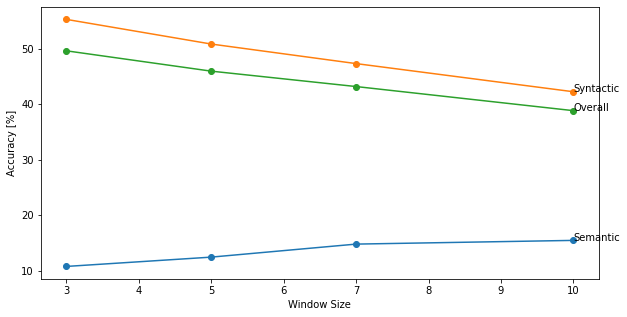

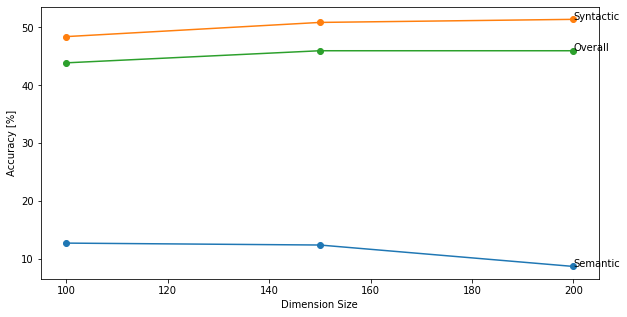

In [79]:
# Use self train gensim word2vec model as instructed, this word2vec one is the best

# Save gensim weight
path = 'model_word2vec_eval.txt'
model_word2vec.wv.save_word2vec_format(path, binary=False)

# Performace instrinsic evalution using standford provided ones
Eval.instrinsic_eval(path)

# Recorded data with plot for different window size and dimension comparison
plot_multi_lines(window_size_list, 'Window Size', w_semantic_list, w_syntactic_list, w_overal_list)
plot_multi_lines(dimension_list, 'Dimension Size', d_semantic_list, d_syntactic_list, d_overal_list)

## 4.2. Performance Evaluation with Data Processing Techiques


You are required to evaluate with the testing dataset and provide the table with f1 of test set.
Note that it will not be marked if you do not display it in the ipynb file.


(*Please show your empirical evidence and justification*)

| Model      | F1 |
| ----------- | ----------- |
| Bi-LSTM With URL      | 0.3771, precision:  0 for class 1, division by 0 issue|
| Bi-LSTM Without URL   | 0.3792, precision:  0.5 for class 1|
| Bi-LSTM Without url, puncation, stopwords, Lemmatisation, lowercase,stemming, number       | 0.440213|
| Bi-LSTM Without url, puncation, stopwords, Lemmatisation, lowercase,stemming    | 0.489996 |
| Bi-LSTM Without url, puncation, stopwords(english), max len=128 (best model)| 0.52864 |

**Note that** the last row is trained with 250 epoch while others are 10.

🍔 **Explain the pattern**

Based on the above table, (1) dataset without url is slightly better while (2) the preprocessing combination with the number is better that without it.

(1) is because:
- It could be that url is not a valuable information to determine whether a person is a thinker or feeler and that given it is a small dataset, the url may not be processed by the model effectively to highlights its importance. 

(2) is because:

- This is explainable as number could be a key factor of the personality type thinker whereas a feeler may use more adjective instead of number to address their comments.

🍔 **Justify my decision**

For the final decision on pre processing, I choose the one **Without url, puncation, stopwords(english)** as it gives the highest f1 score. It is because: 

- **Lemmatisation and stemming not used** not used because it is important to make the vocab as close as possible to the pretrain embedding to maximise the use of it. Both pretrained used are glove and the preprocessing for glove do not involved Lemmatisation and stemming.
- **Remove URL** because the result difference is minimal with or without URL and URL could introduce a big over head in creatign the vocab and the later training process.   
- **Remove english stopwords** because it does not help decide personality.   

Nan / none value

- Min len in training is 57 so nothing is done here.

Length

- Note that the length of sentence is cut off at 512 for training the word embedding and 128 for the model because the embedding need large context words to ensure a better semantic understanding and 128 because I want to train the result fast to make more comparison. 

Some improvement could be:
- instead of remove the url, count the number of it and add it as a feature.
- Before lower case, count number of upper case and add it to features.
- add occurance of punction clusters as feature since a feeler may use more punctions



In [100]:
# Best Preprocessing combinations 
# ONE test case
p2 = {
    'vocab_size': len(word_list),
    'n_class': 2,
    'n_hidden': 32,
    'lr': 1e-3, # learning rate 
    'n_epoch': 20
}
model_preprocessed, _ = Train.train_sequence_model(X_train_encoded, y_train_encoded, p2, emb_dim_concat, emb_table_concat, test_data=[X_test_encoded, y_test_encoded])
print('f1 score: ', Eval.eval_f1_score(model_preprocessed, X_test_encoded, y_test_encoded))

# Because it is a control and treatment group, the model used here is not the best one which is ok based on Ed 


# URL section 
# # Encode input 
# X_train_no_url_encoded = Prep.encode_and_add_padding(X_train_no_url, vocab)
# X_test_no_url_encoded = Prep.encode_and_add_padding(X_test_no_url, vocab)

# model_no_url = Train.train_sequence_model(X_train_no_url_encoded, y_train_encoded, PARAMS, emb_dim_concat, emb_table_concat)
# print()
# Eval.eval_f1_score(model_no_url, X_test_no_url_encoded, y_test_encoded, is_report=True)
# model_preprocessed = Train.train_sequence_model(X_train_encoded, y_train_encoded, PARAMS, emb_dim_concat, emb_table_concat)


Epoch: 1, loss: 0.70424, train_acc: 0.44
Epoch: 2, loss: 0.69765, train_acc: 0.50
Epoch: 3, loss: 0.68138, train_acc: 0.56
Epoch: 4, loss: 0.68906, train_acc: 0.55
Epoch: 5, loss: 0.69850, train_acc: 0.44
Epoch: 6, loss: 0.69582, train_acc: 0.42
Epoch: 7, loss: 0.67972, train_acc: 0.58
Epoch: 8, loss: 0.69424, train_acc: 0.58
Epoch: 9, loss: 0.68024, train_acc: 0.58
Epoch: 10, loss: 0.68372, train_acc: 0.58
Epoch: 11, loss: 0.65952, train_acc: 0.70
Epoch: 12, loss: 0.67881, train_acc: 0.58
Epoch: 13, loss: 0.72361, train_acc: 0.42
Epoch: 14, loss: 0.64051, train_acc: 0.67
Epoch: 15, loss: 0.69414, train_acc: 0.59
Epoch: 16, loss: 0.69932, train_acc: 0.56
Epoch: 17, loss: 0.69692, train_acc: 0.55
Epoch: 18, loss: 0.68037, train_acc: 0.58
Epoch: 19, loss: 0.70640, train_acc: 0.48
Epoch: 20, loss: 0.69266, train_acc: 0.56
f1 score:  0.3966393075271114


## 4.3. Performance Evaluation with Different Input


You are required to evaluate with the testing dataset and provide the table with f1 of test set.
Note that it will not be marked if you do not display it in the ipynb file.


(*Please show your empirical evidence and justification*)

| Model      | F1 |
| ----------- | ----------- |
| Bi-LSTM with Word2vec (SG)   | 0.4446      |
| Bi-LSTM with fasttext (SG)   | 0.3771     |
| Bi-LSTM with glove-twitter-25   | 0.3933       |
| Bi-LSTM with glove-wiki-gigaword-100 | 0.3823    |
| Bi-LSTM with + glove-twitter-25 +  glove-wiki-gigaword-100| 0.4790|
| Bi-LSTM with Word2vec (SG) + fasttext (SG) + glove-twitter-25 + glove-wiki-gigaword-100| 0.4330|

Note that above is tested with 10 epoch.

🎶 **1 Explain the pattern**

🦉 **1.1 Observatoin**

Based on the above table and the model parameters e.g. 10 epoch only,    
- (1) For ***self training*** word embedding, word2vec seems performace better than fasttext by 0.07   
- (2) For ***pretrain*** embedding, the twitter pretrain embedding better than wiki one by 0.01  
- (3) For ***concatentation***, the embedding concatenation of twitter and wiki is better than concatenation with all the self train and pretrain embedding. (0.05+) It is also the best embedding model among other choices.  
- (4) **Compare** self train and pretrain, Word2vec self train is better than any other single word embedding model. Other three models perform similarly.  
- (5) In general, it seems like **the more** different word embeddings, **the** **better** result.

🐨 **1.2 Explanation**

(1), (4) is because:
- It could be since this is a **small dataset**, fasttext n-gram approach and the glove may need more data to be effective to capture the fine representation whereas word2vec is simpler and may not need big data to capture the vector space properly.

(2) is because:

- Twitter may contain more **emotional words** which is helpful in determining the feeler and thus the thinker. Wiki is more **formal** and so not as effective.

(3), (5) is because:

- It is likely that the diversity is more important the quantity for embedding concatenation.This could be why the pretrain concatenation is better than the self train one as pretrain one is from a large corpus with large size and thus diversity.

🎶 **2 Justify my decision**

I choose **Bi-LSTM with + glove-twitter-25 +  glove-wiki-gigaword-100**.  

- Firstly, it gives the highest f1 score compared with others.   
- Secondly, there two mebedding are pretrained with large corpus, the model is thus likely to generate better than other options.   
These two Glove pretrained embedding are considered over other gensim pretrained provided because they are the smallest available which makes the trainign process faster and that the dataset is small so no need for large embedding. 


In [101]:
# Load best model for evalution
# One test case
p2 = {
    'vocab_size': len(word_list),
    'n_class': 2,
    'n_hidden': 32,
    'lr': 1e-3, # learning rate 
    'n_epoch': 20
}
model_input, _ = Train.train_sequence_model(X_train_encoded, y_train_encoded, p2, emb_dim_concat, emb_table_concat, test_data=[X_test_encoded, y_test_encoded])
print('f1 score: ', Eval.eval_f1_score(model_input, X_test_encoded, y_test_encoded))


# Other ones
# model_word2vec_eval = Train.train_sequence_model(X_train_encoded, y_train_encoded, PARAMS, emb_dim_word2vec, emb_table_word2vec)
# model_fastext_eval = Train.train_sequence_model(X_train_encoded, y_train_encoded, PARAMS, emb_dim_fastext, emb_table_fastext)
# model_twitter_eval = Train.train_sequence_model(X_train_encoded, y_train_encoded, PARAMS, emb_dim_twitter, emb_table_twitter)
# model_wiki_eval = Train.train_sequence_model(X_train_encoded, y_train_encoded, PARAMS, emb_dim_wiki, emb_table_wiki)
# etc..

Epoch: 1, loss: 0.70374, train_acc: 0.45
Epoch: 2, loss: 0.69720, train_acc: 0.44
Epoch: 3, loss: 0.71608, train_acc: 0.36
Epoch: 4, loss: 0.72377, train_acc: 0.34
Epoch: 5, loss: 0.69968, train_acc: 0.45
Epoch: 6, loss: 0.68566, train_acc: 0.58
Epoch: 7, loss: 0.68755, train_acc: 0.59
Epoch: 8, loss: 0.69987, train_acc: 0.39
Epoch: 9, loss: 0.68075, train_acc: 0.58
Epoch: 10, loss: 0.68097, train_acc: 0.59
Epoch: 11, loss: 0.69924, train_acc: 0.45
Epoch: 12, loss: 0.68422, train_acc: 0.58
Epoch: 13, loss: 0.69794, train_acc: 0.52
Epoch: 14, loss: 0.69408, train_acc: 0.58
Epoch: 15, loss: 0.67980, train_acc: 0.58
Epoch: 16, loss: 0.70852, train_acc: 0.47
Epoch: 17, loss: 0.68791, train_acc: 0.55
Epoch: 18, loss: 0.70869, train_acc: 0.48
Epoch: 19, loss: 0.70748, train_acc: 0.53
Epoch: 20, loss: 0.67323, train_acc: 0.62
f1 score:  0.3940615472208672


## 4.4. Performance Evaluation with Different Sequence Models


You are required to evaluate with the testing dataset and provide the table with f1 of test set.
Note that it will not be marked if you do not display it in the ipynb file.


(*Please show your empirical evidence and justification*)

All below model has the word mebedding with: ``glove-twitter-25 +  glove-wiki-gigaword-100``, 10 epoches (except for the 150 one).

| Model      | F1 |
| ----------- | ----------- |
| Bi-RNN      | 0.5174      |
| Bi-LSTM   |  0.4790       |
| Bi-GRU   | 0.3874         |
| Bi-LSTM (150 epoch)  |  0.65      |

🎶 **1 Explain the pattern**

🦉 **1.1 Observatoin**

``Bi-RNN > Bi-LSTM > Bi-GRU`` : For f1 score from highest to lowerst.

🐨 **1.2 Explanation**

Given this is a relatively small dataset, the vanishing / exploding graident for RNN may not occur here. Besides, RNN is a relatively simpler model which is perhaps more suitable for this dataset. LSTM and GRU may be a bit more complex for this small dataset.
Therefore, RNN outperformace the others. GRU performs the poorest, it may because it needs some more fine-tuning which is not done or blow justify the reason.   
> "The GRU outperformed the LSTM on all tasks with the exception of language modelling" - [1].

[1] An Empirical Exploration of Recurrent Network Architectures, Google (Ilya, Wojciech, Rafal): http://proceedings.mlr.press/v37/jozefowicz15.pdf

🎈 **2 Justify my decision**

``LSTM + glove-twitter-25 +  glove-wiki-gigaword-100`` is used for the final model choice.   
It is because LSTM can handle longer sequence better than RNN and that its performance is not far from RNN given that the epoch used here is ``10`` only and no parameters tuning is added yet. GRU is not considered given its low f1 score.

In [133]:
# One test case
p2 = {
    'vocab_size': len(word_list),
    'n_class': 2,
    'n_hidden': 32,
    'lr': 1e-3, # learning rate 
    'n_epoch': 20
}
model_seq, _ = Train.train_sequence_model(X_train_encoded, y_train_encoded, p2, emb_dim_concat, emb_table_concat, test_data=[X_test_encoded, y_test_encoded])
print('f1 score: ', Eval.eval_f1_score(model_seq, X_test_encoded, y_test_encoded))


# IMPORTANT: Below result is based on the best model, the table result is determined by a non-best one.
best_model = h.load_best_model()
print('best f1 score: ', Eval.eval_f1_score(best_model, X_test_encoded, y_test_encoded))

# Below is score for the other 2 models, RNN & GRU
# GRU
# model_gru_eval = Train.train_sequence_model(X_train_encoded, y_train_encoded, PARAMS, emb_dim_concat, emb_table_concat, which_=2)
# Eval.eval_f1_score(model_gru_eval, X_test_encoded, y_test_encoded, is_report=True)
# RNN
# model_rnn_eval = Train.train_sequence_model(X_train_encoded, y_train_encoded, PARAMS, emb_dim_concat, emb_table_concat, which_=3)
# Eval.eval_f1_score(model_rnn_eval, X_test_encoded, y_test_encoded, is_report=True)

Epoch: 1, loss: 0.69798, train_acc: 0.45
Epoch: 2, loss: 0.71091, train_acc: 0.44
Epoch: 3, loss: 0.70474, train_acc: 0.47
Epoch: 4, loss: 0.69291, train_acc: 0.52
Epoch: 5, loss: 0.69493, train_acc: 0.53
Epoch: 6, loss: 0.69029, train_acc: 0.56
Epoch: 7, loss: 0.68786, train_acc: 0.61
Epoch: 8, loss: 0.69325, train_acc: 0.53
Epoch: 9, loss: 0.70703, train_acc: 0.45
Epoch: 10, loss: 0.70170, train_acc: 0.47
Epoch: 11, loss: 0.68408, train_acc: 0.62
Epoch: 12, loss: 0.68418, train_acc: 0.53
Epoch: 13, loss: 0.66303, train_acc: 0.67
Epoch: 14, loss: 0.70325, train_acc: 0.48
Epoch: 15, loss: 0.68086, train_acc: 0.56
Epoch: 16, loss: 0.72416, train_acc: 0.44
Epoch: 17, loss: 0.70445, train_acc: 0.47
Epoch: 18, loss: 0.69098, train_acc: 0.50
Epoch: 19, loss: 0.68671, train_acc: 0.55
Epoch: 20, loss: 0.67623, train_acc: 0.59
f1 score:  0.44357715691040633
best f1 score:  0.5559555298167024


## 4.5. HyperParameter Testing
*You are required to draw a graph(y-axis: f1, x-axis: epoch) for test set and explain the optimal number of epochs based on the learning rate you have already chosen.* Note that it will not be marked if you do not display it in the ipynb file.


(*Please show your empirical evidence and justification*)

**README**:  
- Below explanation is **based on the first two charts**.  
- Note that the first 2 chart is the result without using batch size.  
- The last three using the batch size of 64 (added late). 

🎶 **1 Explain the pattern**

🦉 **1.1 Observation**

The model learns (improves it f1 socre) quickly during 0 ~ 40 epoch. Then the learning starts to slow down during 41~100. And after 90th epoch, the model starts to converge and little improvement is observed afte 100th epoch. **(1)**

The learning process for learing rate (lr) of 1e-3 starts **converging** after 100 epoch with f1 score around 0.63 whereas lr of 1e-4 is **still learning** after 150 epoch with f1 score of 0.52 at the 149th epoch.  
**(2)** Given epoch of 150, model with bigger lr converges faster.

🐨 **1.2 Explanation**

(1) is because:
- At the **early** stage, the model quickly forms its representation to understand the relationship between the sequence input and the target type and therefore f1 score improves quickly. During the **middle** stage, such representation is twisted and adjusted with less significant changes on the parameters. At the **late** stage, the represenatation could not be improved due to the **limitation** of:  
💎 small sample size / the low complexity of the model / less fine tuned parameters / the inpropriate preprocessing / the less diverse word embedding.

(2) is because:
- A bigger lr means a **greater update** in the graident which then changes the weights faster after every epoch of training and thus it will learn & converge faster.


🎈 **2 Justify my decision**

The **optimal epoch** chosen is **150**. It is because the later ones seems to be oscillating with little improve in the validation (on testing set). I think further training may lead to overfitting issue that make the model less generalise. And so early stopping at 100 epoch is applied.

**Lr = 1e-3 is chosen**. This is because this lr helps the model to achieve a reasonable f1 score given the small dataset and the simple model. The smaller learning rate is not considered as it converges too slowly. As seen from below, it is at 0.52 f1 score after 150 epoch compared to 0.65. And the smaller one, if **continues this trend** of learning (epoch 130 ~ 150 improve by 0.02), would take about (0.65 - 0.52) / 0.02 * (150-130) = 130 epoch more to reach 0.65 score though this is likely to be a bad estimation.


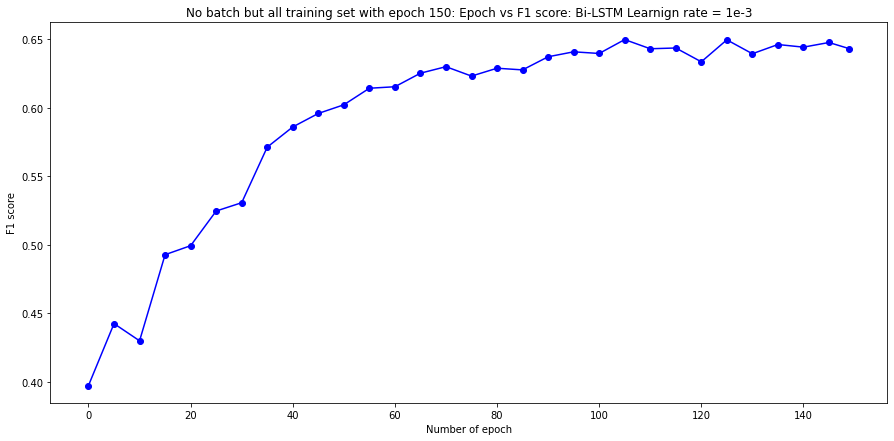

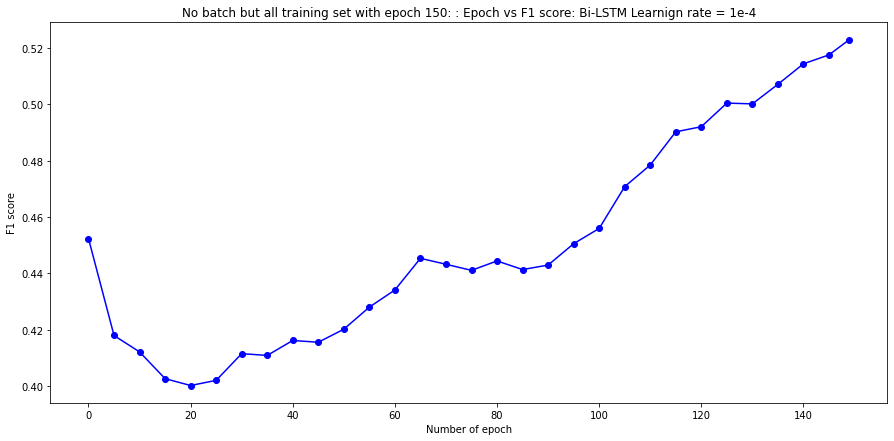

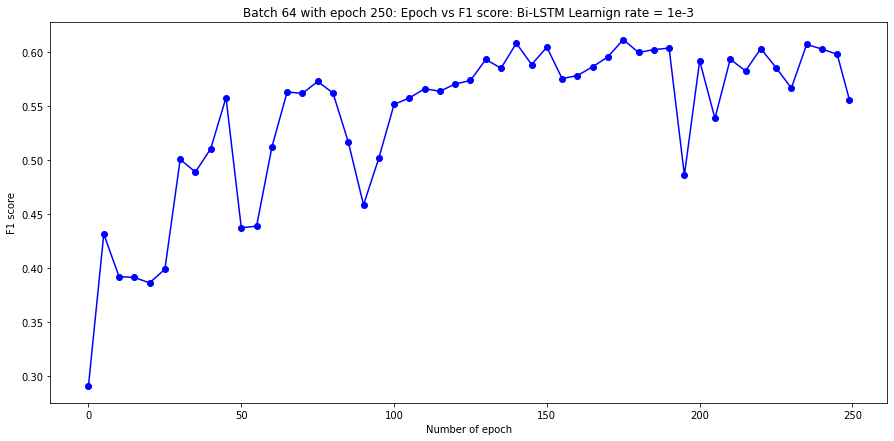

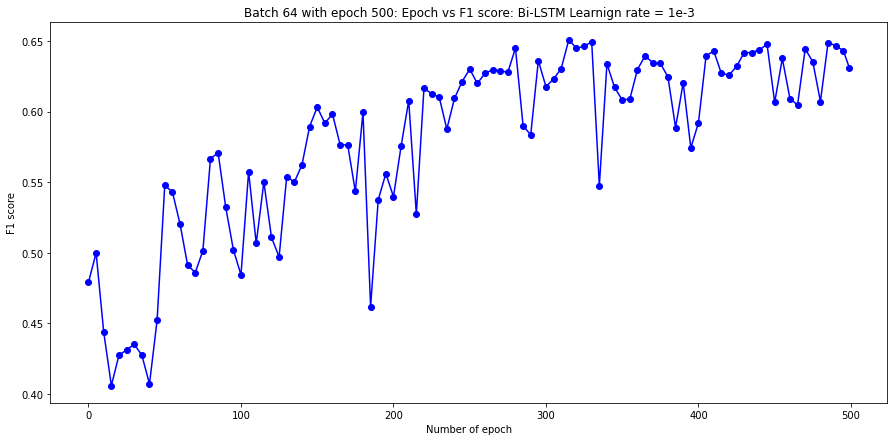

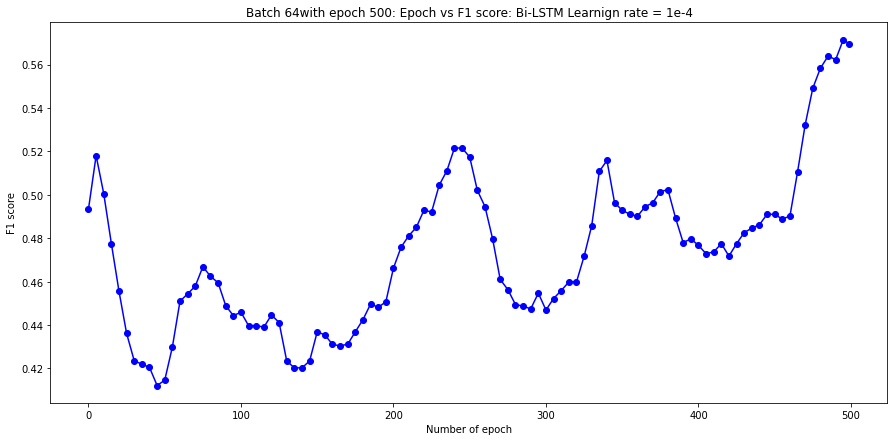

In [108]:
# 💎💎💎 Uncommented Below if use real time data  💎💎💎
# plot_val_history(val_history, title_='Epoch vs F1 score: Bi-LSTM Learnign rate = 1e-3')

plot_val_history(lstm_ep_1e_3, title_='No batch but all training set with epoch 150: Epoch vs F1 score: Bi-LSTM Learnign rate = 1e-3')
plot_val_history(lstm_ep_1e_4, title_='No batch but all training set with epoch 150: : Epoch vs F1 score: Bi-LSTM Learnign rate = 1e-4')
plot_val_history(plot_res_final, title_='Batch 64 with epoch 250: Epoch vs F1 score: Bi-LSTM Learnign rate = 1e-3')
plot_val_history(lstm_1e_3_batch_64, title_='Batch 64 with epoch 500: Epoch vs F1 score: Bi-LSTM Learnign rate = 1e-3')
plot_val_history(lstm_1e_4_batch_64, title_='Batch 64with epoch 500: Epoch vs F1 score: Bi-LSTM Learnign rate = 1e-4')

#5 - Test your model via Colab Form Fields User Interface

You are required to design a user interface so that user can input a textual sentence via the colab form fields user interface to get the personality type classification result from your trained model. *You can just modify based on the following Colab Form Fields template*

In [107]:
#@title Personality Type Prediction

text = 'I am thinking logically'  #@param {type: "string"}

from pathlib import Path
import re
import numpy as np
import os
import json
from google.colab import drive

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as sw
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

from gensim.models import Word2Vec # TODO: Glove
from gensim.models import FastText

import gensim.downloader as api

from typing import * # type hint

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline 
# from IPython.core.interactiveshell import InteractiveShell
# from IPython import get_ipython
# get_ipython().ast_node_interactivity = 'all'

CONFIG = {
    'seed': 23
}

def set_seed(seed=42):
    '''Sets seed so result unchanged - reproducibility'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])
device = torch.device('cpu') # torch.device("cuda" if torch.cuda.is_available() else "cpu")

#################################################################
sww = set(sw.words('english')) # 179 vs 7110 if without specify english
#################################################################
class Bi_LSTM_Emb(nn.Module):
    def __init__(self, vocab_size_, n_hidden_, n_class_, emb_dim_, emb_table_):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size_, emb_dim_)
        # [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.data.copy_(torch.from_numpy(emb_table_))
        # Optional: set requires_grad = False to make this lookup table untrainable
        self.emb.weight.requires_grad = False

        self.lstm = nn.LSTM(emb_dim_, n_hidden_, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden_*2, n_class_)

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        # we will use the returned h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        # details of the outputs from nn.LSTM can be found from: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        # c_n: containing the final cell state for each element in the sequence.
        _, (h_n, c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z

class Preprocessing:
    def __init__(self):
        self.lEnc = LabelEncoder()
    #################################### 1.1 URL Removal #############################
    """
    You are asked to remove the URL from the post. 
    You are asked to compare, by experimental results (in Section 4.2), 
    when you remove the URL from the post versus keeping the URL. 
    Which will you use? (Section 4.2., Justify your decision)
    """
    def template4comment(var_: object) -> object:
        """summary
        Args:
            var(type): comment
        Returns:
            var(type): comment
        """
    def url_removal(self, posts_:List[str]) -> List[str]:
        """remove url from given post
        1. use ||| to split different posts by the same user
        2. use re to remove url with http pattern
        Args:
            post_(str): one instance of the training set
        Returns:
            str: with url removed
        """
        res = []
        for x in posts_:
            # x = x.replace('|||', ' ')
            x = re.sub(r'http\S+', '', x) #TODO: explain
            res.append(x)
        return res

    #################################### 1.2 Preprocess data: for the trained model #############################
    """
    you are asked to pre-process the training set by integrating several 
    tept pre-processing techniques [Lab5] (e.g. tokenisation, removing numbers,
    converting to lowercase, removing stop words, stemming, etc.). 
    You should test and justify the reason why you apply the specific 
    preprocessing techniques based on the test result 
    in section 4.2 (Section 4.2., Justify your decision)
    """
    """
    #Note:
    Order of pre-processing matters, i.e. 
    stop before stemming otherwise word chanegd and cannot be 
    """
    def pre_processing(self, posts_:List[str], is_urls=False, is_stopwords=False, is_number=False, is_encoded=False) -> List[List[str]]:
        """pre-process the training set
        Args:
            posts_(List[str]): comment
        Returns:
            var( List[List[str]] ): a outer list contains a list of word pre-processed tokens, where each inner list represents a post
        """
        res = []
        for x in posts_:
            # separate different posts from the same user
            x = x.replace('|||', ' ')

            if not is_urls:
                x = re.sub(r'http\S+', '', x) 

            # remove puncation
            x = re.sub(r'[^\w\s]','', x) 
            ############################################################## before tokenisation
            # word tokenisation
            x = word_tokenize(x)

            # remove puncation
            x = [re.sub(r'[^\w\s]','', w) for w in x]

            # remove stop words
            if not is_stopwords:
                
                x = [w for w in x if not w in sww]

            # remove number, note this will not remove string contain integer  
            if not is_number:
                x = [w for w in x if not w.isdigit()]
            ############################################################## lab5

            # Lemmatisation 
            lemmatizer = WordNetLemmatizer()
            x = [lemmatizer.lemmatize(w) for w in x]
            ############################################################## lab5
            # convert the tokens into lowercase
            x = [t.lower() for t in x]
            
            # stemming
            stemmer = PorterStemmer()
            x = [stemmer.stem(w) for w in x]

            # remove empty word
            x = [w for w in x if w]

            # assignment
            res.append(x)

        if is_encoded:
            _, vocab_ = self.build_vocab(res)
            return self.encode_and_add_padding(res, vocab_)
        return res
    #################################### 2.1 Word Embedding Construction #############################

    ############################### 2.1 (1): Preprocess data for word embeddings  #########################
        
    def encode_label(self, labels:List[str]) -> List[str]:
        """encode the label from form of str to integer
        Args:
            labels(List[str]): a list of string: either F - Feeler or T - Thinker
        Returns:
            (List[str]): a list of integer labels instead of str labels
        """
        
        # encode the labels 
        # Hint: Try to understand the difference between fit_transform and transform
        return self.lEnc.fit_transform(labels)

    #################### Prepare data ####################
    def encode_and_add_padding(self, sentences:List[str], word_index:dict) -> List[List[int]]:
        """
        Convert the sentences to the word index that aligns with the lookup table
        Args:
            sentences(List[str]): pre-processed posts
            word_index(dict): mapping between unique word to integer
        Returns:
            sent_encoded(List[List[int]]): a list of list containing integer that correspond to each word in a sentece
        """
        
        len_list = [len(s) for s in sentences]
        max_seq_length = 256 #max(len_list) #max length for all input sequence / post
        
        sent_encoded = []

        for sent in sentences:
            # if in then add idx, else integer for the unknown token
            temp_encoded = [word_index[word] if word in word_index else word_index['[UNKNOWN]'] for word in sent] 
            # if len is less than pre-defined, add pad token until same len
            if len(temp_encoded) < max_seq_length:
                temp_encoded += [word_index['[PAD]']] * (max_seq_length - len(temp_encoded)) 
            # exceed. then cutoff
            if len(temp_encoded) > max_seq_length:
                temp_encoded = temp_encoded[:max_seq_length]
            sent_encoded.append(temp_encoded)
        return sent_encoded

Prep_ = Preprocessing()

class Word_embedding:
    def __init__(self):
        pass
    
    ############################### 2.1 (2): Build training model for word embeddings  #########################  
  
    """
    Build training model for word embeddings: You are to build a training model for word embeddings. 
    You are required to articulate the hyperparameters [Lab2] you choose (dimension of embeddings and window size) 
    in Section 4.1. Note that any word embeddings model [Lab2] (e.g. word2vec-CBOW, word2vec-Skip gram, fasttext, glove) 
    can be applied. (Section 4.1. and Section 4.3., Justify your decision)
    """
    def make_self_trained_gensim_model(self, posts_, dimension_=25, window_=3, which_=1) -> Type[Word2Vec]:
        """contruct gensim word2vec model
        Args:
            posts_(List[str]): a list of string: either F - Feeler or T - Thinker
        Returns:
            (gensim.model.Word2Vec): gensim API to create word2vec model
        """
        #TODO: params
        models = {
            1: FastText,
            2: Word2Vec
        }
        return models[which_](sentences=posts_, size=dimension_, window=window_, min_count=5, workers=4, sg=1)

    ############################################### 2.2  Pretrained Word Embedding ##################################################
    """
    You are asked to extract and apply the pretrained word embedding. 
    Gensim provides several pretrained word embeddings, you can find those in the gensim github. 
    You can select the pretrained word embedding that would be useful for the assignment 1 task, 
    personality type classification.(Section 4.3., Justify your decision)
    """

    ######### load gensim pretrain model #########
    """
    Pre trained model based on link here: https://github.com/RaRe-Technologies/gensim-data#models
    """
    def load_pre_train_gensim(self, which_=1) -> object:
        # load the pretrained embedding
        models = {
            1:'glove-twitter-25',
            2: 'glove-wiki-gigaword-100'
        }

        return api.load(models[which_]) # NOTE: Download an embedding other than glove-twitter-255

    ######### build_vocab #########
    def build_vocab(self, docs_:List[List[str]]) -> dict:
        """ build vocabulary based on given dataset
        Args:
            docs_: list of documents that contains string of sentence post
        Returns:
            vocab with key as unique word, value as its mapping integer
        """
        word_set = set() 
        for sent in docs_:
            for word in sent:
                word_set.add(word)
        word_set.add('[PAD]')
        word_set.add('[UNKNOWN]')

        word_list = list(word_set) 
        word_list.sort() # just to make sure order persistent

        word_index = {}
        ind = 0
        for word in word_list:
            word_index[word] = ind
            ind += 1
        return word_list, word_index

    ############################################### 2.3 Input Concatenation ##################################################
    def build_concat_embed_table(self, word_list_: list, word_emb_models:List[object]) -> np.array:
        """ Build the embedding table from the pre-train model.
        Extract those word embedding that exists in the vocab of the current dataset
        Args:
            word_list_(list): a list of unique word in the corpus
        Returns:
            word_emb_models(List[gensim.model]): a list of gensim models
        """
        emb_dim = 0
        for m in word_emb_models:
            emb_dim += m.vector_size

        emb_table = []
        
        for i, word in enumerate(word_list_):
            is_existed = False # initially, assume word does not exist in any embedding 
            concat = []
            if all(word in w_emb for w_emb in word_emb_models): # must all in to ensure shape consistent 
                for w_emb in word_emb_models: # concat all
                    if concat == []: # when empty initalise
                        concat = w_emb[word]
                    else:
                        concat = np.concatenate((concat, w_emb[word]), 0)
                emb_table.append(concat)
            else:
                # The pretrained glove twitter does not contain the embeddings for the [PAD] and [UNKNOWN] tokens we defined
                # Here, we just use all 0 for both [PAD] and [UNKNOWN] tokens for simplicity
                #TODO
                emb_table.append(np.array([0]*emb_dim))

        return np.array(emb_table), emb_dim
Emb_ = Word_embedding()


############################################### 3.2. Train Sequence Model (Bi-directional model) ###############################################
class Train_model:
    def __init__(self):
        pass
    def train_sequence_model(self, X_train_, y_train_, params:dict, emb_dim, emb_table, which_=1, test_data=[]):
        """train the sequence model"""
        assert type(which_) == int, 'type(which_) == int'
        assert type(test_data) == list, 'type(test_data) == list'
        assert type(emb_dim) == int, 'type(emb_dim) == int'

        p = params
        vocab_size, n_class, n_hidden, lr_, n_epoch = p['vocab_size'], p['n_class'], p['n_hidden'], p['lr'], p['n_epoch']

        model = None
        # Move the model to GPU
        if which_ == 1:
            model = Bi_LSTM_Emb(vocab_size, n_hidden, n_class, emb_dim, emb_table).to(device)
        elif which_ == 2:
            model = Bi_GRU(vocab_size, n_hidden, n_class, emb_dim, emb_table).to(device)
        elif which_ ==3:
            model = Bi_RNN(vocab_size, n_hidden, n_class, emb_dim, emb_table).to(device)
        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr_)

        # Preparing input
        input_torch = torch.from_numpy(np.array(X_train_)).to(device)
        targe_torch = torch.from_numpy(np.array(y_train_)).view(-1).to(device)
        
        plot = []

        for epoch in range(n_epoch):  
            
            # Set the flag to training
            model.train()
            
            # forward + backward + optimize
            optimizer.zero_grad()
            outputs = model(input_torch) 
            loss = criterion(outputs, targe_torch)
            loss.backward()
            optimizer.step()
            
            predicted = torch.argmax(outputs, -1)
            acc = -1
            
            acc= accuracy_score(predicted.cpu().numpy(),targe_torch.cpu().numpy())
            print('Epoch: %d, loss: %.5f, train_acc: %.2f' %(epoch + 1, loss.item(), acc))
            eval_tmp = Instrinsic_eval()
            if test_data != [] and (epoch % 5 == 0 or epoch == n_epoch - 1):
                f1 = eval_tmp.eval_f1_score(model, test_data[0], test_data[1])
                plot.append([epoch, f1])
        if test_data != []:
            return model, plot
        return model
        
Train_ = Train_model()

########################################################################################################################
############################################### Full run logic #########################################################
########################################################################################################################

def run_pipeline():
    
    X_train_ori = training_posts
    y_train_ori = training_labels

    X_train_ = Prep_.pre_processing(X_train_ori)
    #TODO: donwload
    X_train_encoded_ = Prep_.encode_and_add_padding(X_train_, vocab)
    y_train_encoded_ = Prep_.encode_label(y_train_ori)

    word_list_, vocab_ = Emb_.build_vocab(X_train_)

    PARAMS_ = {
            'vocab_size': 69071, # 69071, # len(word_list)
            'n_class': 2,
            'n_hidden': 32,
            'lr': 1e-3, # learning rate 
            'n_epoch': 150
        }

    model_twitter_ = Emb_.load_pre_train_gensim(which_=1)
    model_gigaword_ = Emb_.load_pre_train_gensim(which_=2)

    emb_table_concat_, emb_dim_concat_ = Emb_.build_concat_embed_table(word_list_, [model_twitter_, model_gigaword_]) 

    return Train_.train_sequence_model(X_train_encoded_, y_train_encoded_, PARAMS_, emb_dim_concat_, emb_table_concat_) 

########################################################################################################################
############################################### Load downloaded torch model ############################################
########################################################################################################################

def load_local_torch_model(model_, path_:str):
    
    model_.load_state_dict(torch.load(path_))
    return model_

def load_local_numpy_txt(path_:str):
        
    return np.loadtxt(path_, dtype=np.float64)

def download_best_model_gdrive():
    # Code to download file into Colaboratory:
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    # Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)


    id = '16g474hdNsaNx0_SnoKuqj2BuwSEGdnbt'
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('training_data.csv')  

    id = '1-7hj0sF3Rc5G6POKdkpbDXm_Q6BWFDPU'
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('testing_data.csv')  

    import pandas as pd
    training_data = pd.read_csv("/content/training_data.csv")
    testing_data = pd.read_csv("/content/testing_data.csv")


    # Extract the labels and posts and store into List

    # Get the list of training data (posts)
    training_posts=training_data['posts'].tolist()
    # Get the list of corresponding labels for the training data (posts)
    training_labels=training_data['type'].tolist()

    # Get the list of testing data (posts)
    testing_posts=testing_data['posts'].tolist()
    # Get the list of corresponding labels for the testing data (posts)
    testing_labels=testing_data['type'].tolist()

    ############################################################################################################

    id = '15w8MO5FjQAxt9chIOEWEBWiXktA5xOjz'
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(best_model_path) 

    id = '1-CKuXmWSb75rejxAWpaHZE7PWQ_YuoiZ'
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(best_embed_path)  

    id = '1LDzY7S-Mqbm4xGWdVNvS4BaBS1QZ8waz'
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(vocab_path)  
    
def make_prediction(input_):
     
    model_file = Path(best_model_path)
    embed_file = Path(best_embed_path)
    vocab_file = Path(vocab_path)
    
    PARAMS_ = {
        'vocab_size': 69071, # len(word_list)
        'n_class': 2,
        'n_hidden': 32,
        'lr': 1e-3, # learning rate 
        'n_epoch': 150
    }
    if not all([model_file.is_file(), embed_file.is_file(), vocab_file.is_file()]): # check if file exists
        
        # download the saved word embedding for the model and the model weight in order to reuse the best model
        download_best_model_gdrive()

    # Load data from json file
    with open(vocab_path,'r') as f:
        vocab_ = json.load(f)['data']
    emb_dim_concat_ = 125 # 25 (twitter) + 100 (wiki)
    emb_table_concat_ = load_local_numpy_txt(best_embed_path)
    model_ = Bi_LSTM_Emb(PARAMS_['vocab_size'], PARAMS_['n_hidden'], PARAMS_['n_class'], emb_dim_concat_, emb_table_concat_)
    model_ = load_local_torch_model(model_, best_model_path)
        
    # 💎 Uncomment below to run the full pipeline from preprocessing to training
    # model_ = run_pipeline()
    
    text_processed = Prep_.pre_processing([input_])
    text_encoded = Prep_.encode_and_add_padding(text_processed, vocab_)

    input_torch = torch.from_numpy(np.array(text_encoded)).to(device)
    outputs = model_(input_torch) 
    predicted = torch.argmax(outputs, -1)
    return predicted.cpu().numpy()

best_model_path = 'best_model.pth'
best_embed_path = 'best_embed.txt'
vocab_path = 'vocab.json'

res1 = make_prediction(text)[0]
res2 = 'F' if res1 == 0 else 'T'

print("Predicted Personality Type: ", res2) # transform back from integer to its orginal label

Predicted Personality Type:  T


# Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed* 

## Import & Set seed

In [109]:
import re
import numpy as np
import os
import json
from google.colab import drive
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as sw
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

from gensim.models import Word2Vec # TODO: Glove
from gensim.models import FastText

import gensim.downloader as api

from typing import * # type hint

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline 
# from IPython.core.interactiveshell import InteractiveShell
# from IPython import get_ipython
# get_ipython().ast_node_interactivity = 'all'

CONFIG = {
    'seed': 23
}

def set_seed(seed=42):
    '''Sets seed so result unchanged - reproducibility'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])
device = torch.device('cpu') #torch.device("cuda" if torch.cuda.is_available() else "cpu")

!git clone --quiet https://github.com/stanfordnlp/GloVe.git # for the instrinic evalution

sww = set(sw.words('english')) # 179 vs 7110 if without specify english

fatal: destination path 'GloVe' already exists and is not an empty directory.


## class - sequence model 

In [110]:
############################################### 3.1 Build Sequence Model (Bi-directional model) ##################################################

#################### Bi-GRU ####################
class Bi_GRU(nn.Module):
    def __init__(self, vocab_size, n_hidden, n_class, emb_dim, emb_table):
        super(Bi_GRU, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        # [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        # Optional: set requires_grad = False to make this lookup table untrainable
        self.emb.weight.requires_grad = False

        self.gru = nn.GRU(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        # we will use the returned h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        # details of the outputs from nn.LSTM can be found from: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        # c_n: containing the final cell state for each element in the sequence.
        _, h_n = self.gru(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z
#################### RNN ####################
class Bi_RNN(nn.Module):
    def __init__(self, vocab_size, n_hidden, n_class, emb_dim, emb_table):
        super(Bi_RNN, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        # [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        # Optional: set requires_grad = False to make this lookup table untrainable
        self.emb.weight.requires_grad = False

        self.rnn = nn.RNN(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        # we will use the returned h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        # details of the outputs from nn.LSTM can be found from: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        # c_n: containing the final cell state for each element in the sequence.
        _, h_n = self.rnn(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z

## class - Preprocessing

In [111]:
class Preprocessing:
    def __init__(self):
        self.lEnc = LabelEncoder()
    #################################### 1.1 URL Removal #############################
    """
    You are asked to remove the URL from the post. 
    You are asked to compare, by experimental results (in Section 4.2), 
    when you remove the URL from the post versus keeping the URL. 
    Which will you use? (Section 4.2., Justify your decision)
    """
    def template4comment(var_: object) -> object:
        """summary
        Args:
            var(type): comment
        Returns:
            var(type): comment
        """
    def url_removal(self, posts_:List[str]) -> List[str]:
        """remove url from given post
        1. use ||| to split different posts by the same user
        2. use re to remove url with http pattern
        Args:
            post_(str): one instance of the training set
        Returns:
            str: with url removed
        """
        res = []
        for x in posts_:
            # x = x.replace('|||', ' ')
            x = re.sub(r'http\S+', '', x) #TODO: explain
            res.append(x)
        return res

    #################################### 1.2 Preprocess data: for the trained model #############################
    """
    you are asked to pre-process the training set by integrating several 
    tept pre-processing techniques [Lab5] (e.g. tokenisation, removing numbers,
    converting to lowercase, removing stop words, stemming, etc.). 
    You should test and justify the reason why you apply the specific 
    preprocessing techniques based on the test result 
    in section 4.2 (Section 4.2., Justify your decision)
    """
    """
    #Note:
    Order of pre-processing matters, i.e. 
    stop before stemming otherwise word chanegd and cannot be 
    """
    def pre_processing(self, posts_:List[str], is_urls=False, is_stopwords=False, is_number=True, is_lemm=False, is_stem=False) -> List[List[str]]:
        """pre-process the training set
        Args:
            posts_(List[str]): comment
        Returns:
            var( List[List[str]] ): a outer list contains a list of word pre-processed tokens, where each inner list represents a post
        """
        res = []
        for x in posts_:
            # separate different posts from the same user
            x = x.replace('|||', ' ')

            if not is_urls:
                x = re.sub(r'http\S+', '', x) 

            ############################################################## before tokenisation
            # word tokenisation
            x = word_tokenize(x)
            max_len = 512
            x = x[:max_len]
            # remove puncation
            x = [re.sub(r'[^\w\s]','', w) for w in x]

            # remove stop words
            if not is_stopwords:
                
                x = [w for w in x if not w in sww]

            # remove number, note this will not remove string contain integer  
            if not is_number:
                x = [w for w in x if not w.isdigit()]
            ############################################################## lab5

            # Lemmatisation 
            if is_lemm:
                lemmatizer = WordNetLemmatizer()
                x = [lemmatizer.lemmatize(w) for w in x]
            ############################################################## lab5
            # convert the tokens into lowercase
            x = [t.lower() for t in x]
            
            # stemming
            if is_stem:
                stemmer = PorterStemmer()
                x = [stemmer.stem(w) for w in x]

            # remove empty word
            x = [w for w in x if w]

            # assignment
            res.append(x)

        return res
    #################################### 2.1 Word Embedding Construction #############################

    ############################### 2.1 (1): Preprocess data for word embeddings  #########################
        
    def encode_label(self, labels:List[str]) -> List[str]:
        """encode the label from form of str to integer
        Args:
            labels(List[str]): a list of string: either F - Feeler or T - Thinker
        Returns:
            (List[str]): a list of integer labels instead of str labels
        """
        
        # encode the labels 
        # Hint: Try to understand the difference between fit_transform and transform
        return self.lEnc.fit_transform(labels)

    #################### Prepare data ####################
    def encode_and_add_padding(self, sentences:List[str], word_index:dict) -> List[List[int]]:
        """
        Convert the sentences to the word index that aligns with the lookup table
        Args:
            sentences(List[str]): pre-processed posts
            word_index(dict): mapping between unique word to integer
        Returns:
            sent_encoded(List[List[int]]): a list of list containing integer that correspond to each word in a sentece
        """
        
        len_list = [len(s) for s in sentences]
        max_seq_length = 128 #max(len_list) #max length for all input sequence / post
        
        sent_encoded = []

        for sent in sentences:
            # if in then add idx, else integer for the unknown token
            temp_encoded = [word_index[word] if word in word_index else word_index['[UNKNOWN]'] for word in sent] 
            # if len is less than pre-defined, add pad token until same len
            if len(temp_encoded) < max_seq_length:
                temp_encoded += [word_index['[PAD]']] * (max_seq_length - len(temp_encoded)) 
            # exceed. then cutoff
            if len(temp_encoded) > max_seq_length:
                temp_encoded = temp_encoded[:max_seq_length]
            sent_encoded.append(temp_encoded)
        return sent_encoded

Prep = Preprocessing()

## class - Word_embedding

In [112]:
class Word_embedding:
    def __init__(self):
        pass
    
    ############################### 2.1 (2): Build training model for word embeddings  #########################  
  
    """
    Build training model for word embeddings: You are to build a training model for word embeddings. 
    You are required to articulate the hyperparameters [Lab2] you choose (dimension of embeddings and window size) 
    in Section 4.1. Note that any word embeddings model [Lab2] (e.g. word2vec-CBOW, word2vec-Skip gram, fasttext, glove) 
    can be applied. (Section 4.1. and Section 4.3., Justify your decision)
    """
    def make_self_trained_gensim_model(self, posts_, dimension_=25, window_=3, which_=1) -> Type[Word2Vec]:
        """contruct gensim word2vec model
        Args:
            posts_(List[str]): a list of string: either F - Feeler or T - Thinker
        Returns:
            (gensim.model.Word2Vec): gensim API to create word2vec model
        """
        #TODO: params
        models = {
            1: FastText,
            2: Word2Vec
        }
        return models[which_](sentences=posts_, size=dimension_, window=window_, min_count=5, workers=4, sg=1)

    ############################################### 2.2  Pretrained Word Embedding ##################################################
    """
    You are asked to extract and apply the pretrained word embedding. 
    Gensim provides several pretrained word embeddings, you can find those in the gensim github. 
    You can select the pretrained word embedding that would be useful for the assignment 1 task, 
    personality type classification.(Section 4.3., Justify your decision)
    """

    ######### load gensim pretrain model #########
    """
    Pre trained model based on link here: https://github.com/RaRe-Technologies/gensim-data#models
    """
    def load_pre_train_gensim(self, which_=1) -> object:
        # load the pretrained embedding
        models = {
            1:'glove-twitter-25',
            2: 'glove-wiki-gigaword-100',
            # 3: 'fasttext-wiki-news-subwords-300'
        }

        return api.load(models[which_]) # NOTE: Download an embedding other than glove-twitter-255

    ######### build_vocab #########
    def build_vocab(self, docs_:List[List[str]]) -> dict:
        """ build vocabulary based on given dataset
        Args:
            docs_: list of documents that contains string of sentence post
        Returns:
            vocab with key as unique word, value as its mapping integer
        """
        word_set = set() 
        for sent in docs_:
            for word in sent:
                word_set.add(word)
        word_set.add('[PAD]')
        word_set.add('[UNKNOWN]')

        word_list = list(word_set) 
        word_list.sort() # just to make sure order persistent

        word_index = {}
        ind = 0
        for word in word_list:
            word_index[word] = ind
            ind += 1
        return word_list, word_index

    ############################################### 2.3 Input Concatenation ##################################################
    def build_concat_embed_table(self, word_list_: list, word_emb_models:List[object]) -> np.array:
        """ Build the embedding table from the pre-train model.
        Extract those word embedding that exists in the vocab of the current dataset
        Args:
            word_list_(list): a list of unique word in the corpus
        Returns:
            word_emb_models(List[gensim.model]): a list of gensim models
        """
        emb_dim = 0
        for m in word_emb_models:
            emb_dim += m.vector_size

        emb_table = []
        
        for i, word in enumerate(word_list_):
            is_existed = False # initially, assume word does not exist in any embedding 
            concat = []
            if all(word in w_emb for w_emb in word_emb_models): # must all in to ensure shape consistent 
                for w_emb in word_emb_models: # concat all
                    if concat == []: # when empty initalise
                        concat = w_emb[word]
                    else:
                        concat = np.concatenate((concat, w_emb[word]), 0)
                emb_table.append(concat)
            else:
                # The pretrained glove twitter does not contain the embeddings for the [PAD] and [UNKNOWN] tokens we defined
                # Here, we just use all 0 for both [PAD] and [UNKNOWN] tokens for simplicity
                #TODO
                emb_table.append(np.array([0]*emb_dim))

        return np.array(emb_table), emb_dim
Emb = Word_embedding()

## class - Train 

In [113]:
############################################### 3.2. Train Sequence Model (Bi-directional model) ###############################################
class Train_model:
    def __init__(self):
        pass
    def train_sequence_model(self, X_train_, y_train_, params:dict, emb_dim, emb_table, which_=1, test_data=[]):
        """train the sequence model"""
        assert type(which_) == int, 'type(which_) == int'
        assert type(test_data) == list, 'type(test_data) == list'
        assert type(emb_dim) == int, 'type(emb_dim) == int'
        p = params
        vocab_size, n_class, n_hidden, lr_, n_epoch = p['vocab_size'], p['n_class'], p['n_hidden'], p['lr'], p['n_epoch']

        model = None
        # Move the model to GPU
        if which_ == 1:
            model = Bi_LSTM_Emb(vocab_size, n_hidden, n_class, emb_dim, emb_table).to(device)
        elif which_ == 2:
            model = Bi_GRU(vocab_size, n_hidden, n_class, emb_dim, emb_table).to(device)
        elif which_ ==3:
            model = Bi_RNN(vocab_size, n_hidden, n_class, emb_dim, emb_table).to(device)

        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr_)
        
        plot = []
        # Parameters
        params_dataset = {'batch_size': 64,
                'shuffle': True,
                'num_workers': 2}

        # Generators
        X_torch = torch.from_numpy(np.array(X_train_))
        y_torch = torch.from_numpy(np.array(y_train_)).view(-1) # view(-1) because it is pass in as a list
        
        training_set = CustomDataSet(X_torch, y_torch)
        training_generator = torch.utils.data.DataLoader(training_set, **params_dataset)
        
        # Loop over epochs

        for epoch in range(n_epoch):
            # Training
            for local_batch, local_labels in training_generator:
                # Transfer to GPU
                local_batch, local_labels = local_batch.to(device), local_labels.to(device)

            # Model computations
            
            # Set the flag to training
            model.train()
            
            # forward + backward + optimize
            optimizer.zero_grad()
            outputs = model(local_batch) 
            loss = criterion(outputs, local_labels)
            loss.backward()
            optimizer.step()
            
            predicted = torch.argmax(outputs, -1)            
            
            acc= accuracy_score(predicted.cpu().numpy(),local_labels.cpu().numpy())
            print('Epoch: %d, loss: %.5f, train_acc: %.2f' %(epoch + 1, loss.item(), acc))
            
            if test_data != [] and (epoch % 5 == 0 or epoch == n_epoch - 1):
                eval_tmp = Instrinsic_eval()
                f1 = eval_tmp.eval_f1_score(model, test_data[0], test_data[1])
                plot.append([epoch, f1])

        if test_data != []:
            return model, plot
        return model
        
        #####################################################################################
Train = Train_model()

## class - instrinsic eval

In [114]:
 class Instrinsic_eval:
    def __init__(self):
        pass
    
    def eval_f1_score(self, model_, X_test_, y_test_, is_report=False):
        model_.eval()
        input_torch = torch.from_numpy(np.array(X_test_)).to(device)

        outputs = model_(input_torch) 
        predicted = torch.argmax(outputs, -1)
        if is_report:
            print('F1 score: ', f1_score(y_test_, predicted.cpu().numpy(), average='weighted'))
            print()
            print(classification_report(y_test_,predicted.cpu().numpy()))
            return
        return f1_score(y_test_, predicted.cpu().numpy(), average='weighted')

    ############################################### 4.1. instrinsic evaluation ###############################################

    def instrinsic_eval(self, path:str):
        """
        This is for the model that is trained
        The example code is provided here - Word Embedding Intrinsic Evaluation
        ou also are to visualise the result (the example can be found in the Table 2 and Figure 2 from the Original GloVe Paper).
        code: https://colab.research.google.com/drive/1VdNkQpeI6iLPHeTsGe6sdHQFcGyV1Kmi?usp=sharing#scrollTo=n-LHSUrn7IKh
        """

        ################# 
        # Download Google Analogy Test Set questions
        

        ################# 
        # The following code will save the trained embedding vectors in a text format.
        """
        9: 9 vectors, 4: dimension of 4
        Below is actual file content for the first few lines

        ```txt
        9 4
        word1 0.123 0.134 0.532 0.152
        word2 0.934 0.412 0.532 0.159
        ```

        """

        #################
        # Below based on evaluation code in stanfordnlp glove github
        # Basic get embedding for later intrinsic evalution
        vectors_file=path

        with open(vectors_file, 'r') as f:
            vectors = {}
            for line in f.readlines()[1:]: # we only need the embedding vectors starting from the second line 
                vals = line.rstrip().split(' ')
                vectors[vals[0]] = [float(x) for x in vals[1:]]

        #################
        # convert the format to desire mapping
        vocab_words=list(vectors.keys())
        vocab_size = len(vocab_words)
        print("Vocab size: ",str(vocab_size))

        # create word->index and index->word converter
        vocab = {w: idx for idx, w in enumerate(vocab_words)}
        ivocab = {idx: w for idx, w in enumerate(vocab_words)}
        #################
        # create matrix & normalisation

        # create the embedding matrix of shape (vocab_size, dim)
        vector_dim = len(vectors[ivocab[0]])
        W = np.zeros((vocab_size, vector_dim))
        for word, v in vectors.items():
            if word == '<unk>':
                continue
            W[vocab[word], :] = v
        #################
        # normalize each word vector to unit length
        # Vectors are usually normalized to unit length before they are used for similarity calculation, making cosine similarity and dot-product equivalent.
        W_norm = np.zeros(W.shape)
        d = (np.sum(W ** 2, 1) ** (0.5))
        W_norm = (W.T / d).T
        #################

        correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count = self.evaluate_vectors(W_norm, vocab, prefix='GloVe/eval/question-data')
        print('Questions seen/total: %.2f%% (%d/%d)' %
            (100 * count_tot / float(full_count), count_tot, full_count))
        print('Semantic accuracy: %.2f%%  (%i/%i)' %
            (100 * correct_sem / float(count_sem), correct_sem, count_sem))
        print('Syntactic accuracy: %.2f%%  (%i/%i)' %
            (100 * correct_syn / float(count_syn), correct_syn, count_syn))
        print('Total accuracy: %.2f%%  (%i/%i)' % (100 * correct_tot / float(count_tot), correct_tot, count_tot))

    def evaluate_vectors(self, W, vocab, prefix='./eval/question-data/'):
        """Evaluate the trained word vectors on a variety of tasks"""

        filenames = [
            'capital-common-countries.txt', 'capital-world.txt', 'currency.txt',
            'city-in-state.txt', 'family.txt', 'gram1-adjective-to-adverb.txt',
            'gram2-opposite.txt', 'gram3-comparative.txt', 'gram4-superlative.txt',
            'gram5-present-participle.txt', 'gram6-nationality-adjective.txt',
            'gram7-past-tense.txt', 'gram8-plural.txt', 'gram9-plural-verbs.txt',
            ]

        # to avoid memory overflow, could be increased/decreased
        # depending on system and vocab size
        split_size = 100

        correct_sem = 0; # count correct semantic questions
        correct_syn = 0; # count correct syntactic questions
        correct_tot = 0 # count correct questions
        count_sem = 0; # count all semantic questions
        count_syn = 0; # count all syntactic questions
        count_tot = 0 # count all questions
        full_count = 0 # count all questions, including those with unknown words

        for i in range(len(filenames)):
            with open('%s/%s' % (prefix, filenames[i]), 'r') as f:
                full_data = [line.rstrip().split(' ') for line in f]
                full_count += len(full_data)
                data = [x for x in full_data if all(word in vocab for word in x)]

            if len(data) == 0:
                print("ERROR: no lines of vocab kept for %s !" % filenames[i])
                print("Example missing line:", full_data[0])
                continue

            indices = np.array([[vocab[word] for word in row] for row in data])
            ind1, ind2, ind3, ind4 = indices.T

            predictions = np.zeros((len(indices),))
            num_iter = int(np.ceil(len(indices) / float(split_size)))
            for j in range(num_iter):
                subset = np.arange(j*split_size, min((j + 1)*split_size, len(ind1)))

                pred_vec = (W[ind2[subset], :] - W[ind1[subset], :]
                    +  W[ind3[subset], :])

                #cosine similarity if input W has been normalized
                dist = np.dot(W, pred_vec.T)


                for k in range(len(subset)):
                    dist[ind1[subset[k]], k] = -np.Inf
                    dist[ind2[subset[k]], k] = -np.Inf
                    dist[ind3[subset[k]], k] = -np.Inf

                # predicted word index
                predictions[subset] = np.argmax(dist, 0).flatten()

            
            val = (ind4 == predictions) # correct predictions
            count_tot = count_tot + len(ind1)
            correct_tot = correct_tot + sum(val)
            if i < 5:
                count_sem = count_sem + len(ind1)
                correct_sem = correct_sem + sum(val)
            else:
                count_syn = count_syn + len(ind1)
                correct_syn = correct_syn + sum(val)

            print("%s:" % filenames[i])
            print('ACCURACY TOP1: %.2f%% (%d/%d)' %
                (np.mean(val) * 100, np.sum(val), len(val)))
            
        return correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count
Eval = Instrinsic_eval()

## 4.1 preprocess combo compare

In [115]:
import matplotlib.pyplot as plt
# Dimension feature
dimension_list = [100, 150, 200]
d_semantic_list = [12.75, 12.42, 8.72]
d_syntactic_list = [48.41, 50.86, 51.39]
d_overal_list = [43.88, 45.97, 45.97]

# Window size 
window_size_list = [3, 5, 7, 10]
w_semantic_list = [10.74, 12.42, 14.77, 15.44]
w_syntactic_list = [55.31, 50.86, 47.33, 42.25]
w_overal_list = [49.64, 45.97, 43.19, 38.84]

def plot_multi_lines(x, x_label, semantic_list_, syntactic_list_, overal_list_):

    labels  = {'Semantic': semantic_list_, 
               'Syntactic': syntactic_list_, 
               'Overall': overal_list_
               }
    
    plt.figure(0, figsize=(10,5))
    
    for k, y in labels.items():
        plt.plot(x, y, marker='o')
        plt.text(x[-1], y[-1], f"{k}") # text(x, y, some_text), where x is last index for each line
        # add text at end of line (10 is the orginal x-axis label which is chanegd later on)
        
    #plt.legend(labels, loc='upper right')
    plt.ylabel('Accuracy [%]')
    plt.xlabel(x_label)
    # positions = [i for i in range(11)]
    # x_labels = sizes
    # plt.xticks(positions, x_labels)
    
    plt.show()

## 4.5 hyperparams tuning & data

Contain manually save data, and plot function

In [116]:

# Learning rate = 1e-3
lstm_ep_1e_3 = [[0, 0.39722835039723087],
 [5, 0.4423827587975953],
 [10, 0.42984313547950204],
 [15, 0.4926813580401134],
 [20, 0.4992443784462104],
 [25, 0.5245338268877596],
 [30, 0.5306104496008943],
 [35, 0.571148231826966],
 [40, 0.5858739622895017],
 [45, 0.5957303518771649],
 [50, 0.6020399043944912],
 [55, 0.614119366403292],
 [60, 0.6152170210349143],
 [65, 0.625110054864376],
 [70, 0.6298528726404834],
 [75, 0.6229937133550588],
 [80, 0.6287271067130272],
 [85, 0.627513288903641],
 [90, 0.63708728564391],
 [95, 0.6406995533900709],
 [100, 0.6394967646501325],
 [105, 0.6496326661647691],
 [110, 0.6429373137472711],
 [115, 0.6434909601240305],
 [120, 0.6334229428466362],
 [125, 0.6494375198520522],
 [130, 0.6393020458593476],
 [135, 0.6460219453556341],
 [140, 0.6441044978063931],
 [145, 0.647501483381419],
 [149, 0.6429745321971257]]

# learning rate = 1e-4 

lstm_ep_1e_4 = [[0, 0.4523876403925913],
 [5, 0.41798941072273454],
 [10, 0.41216740632084864],
 [15, 0.40267291445184034],
 [20, 0.40024746705331604],
 [25, 0.4020764254516451],
 [30, 0.41154427747616645],
 [35, 0.4109207172903444],
 [40, 0.4162233872394977],
 [45, 0.41559035667904637],
 [50, 0.42022412401525167],
 [55, 0.42806439409999625],
 [60, 0.4341450946228735],
 [65, 0.44536590124890546],
 [70, 0.4432629830791194],
 [75, 0.44109912579157584],
 [80, 0.4444444470026792],
 [85, 0.44138306405150607],
 [90, 0.4429774411197592],
 [95, 0.45055341441534363],
 [100, 0.4559701893042565],
 [105, 0.4707978418741552],
 [110, 0.478475389974241],
 [115, 0.49025470500383994],
 [120, 0.49206442773521886],
 [125, 0.5004443663505393],
 [130, 0.500165534942555],
 [135, 0.507110374240826],
 [140, 0.5143752540607812],
 [145, 0.5175457304692035],
 [149, 0.5229774691199987]]
# hidden = 32
lstm_1e_3_batch_64 = \
[[0, 0.47919457279822786],
 [5, 0.4999697266630849],
 [10, 0.4437178192414033],
 [15, 0.4060926393619775],
 [20, 0.42763861868516967],
 [25, 0.43123462199570695],
 [30, 0.4352723383568304],
 [35, 0.4275300852110676],
 [40, 0.40717003933262425],
 [45, 0.45241747266283433],
 [50, 0.5476665515163629],
 [55, 0.5432185015283442],
 [60, 0.5206169339788286],
 [65, 0.4913033173933436],
 [70, 0.4860421038899289],
 [75, 0.5014581815322253],
 [80, 0.5666760980828982],
 [85, 0.5708434242983643],
 [90, 0.5322840828415608],
 [95, 0.5022165915094046],
 [100, 0.4844128672411702],
 [105, 0.5573522709090807],
 [110, 0.5067051657120623],
 [115, 0.5501165691958634],
 [120, 0.5108916609826263],
 [125, 0.4970844546969114],
 [130, 0.55402462658386],
 [135, 0.5500895683645591],
 [140, 0.5622822792517499],
 [145, 0.5893549136573506],
 [150, 0.6031532831116099],
 [155, 0.5918066302378698],
 [160, 0.5981896844845174],
 [165, 0.5766750018430263],
 [170, 0.5762285367850134],
 [175, 0.5434906977811584],
 [180, 0.5994304010227302],
 [185, 0.4618307978991708],
 [190, 0.5375042743652012],
 [195, 0.5560940598700497],
 [200, 0.5397791734388953],
 [205, 0.5755286770959477],
 [210, 0.6077266541580119],
 [215, 0.5274067733430385],
 [220, 0.6164755059460085],
 [225, 0.6127152635016919],
 [230, 0.6101742665256591],
 [235, 0.5875667544653554],
 [240, 0.6093183047595814],
 [245, 0.6212028562138994],
 [250, 0.6300481356301687],
 [255, 0.6199111687725465],
 [260, 0.627022272083034],
 [265, 0.6296538958237122],
 [270, 0.628831600086741],
 [275, 0.6277966658762477],
 [280, 0.64487174574721],
 [285, 0.5899821610302591],
 [290, 0.5835005748221509],
 [295, 0.6360361057221893],
 [300, 0.6176269585921745],
 [305, 0.6230845432513964],
 [310, 0.6304356331227516],
 [315, 0.6509565613517861],
 [320, 0.6446956364968478],
 [325, 0.6463484580978437],
 [330, 0.6492676704067548],
 [335, 0.5474612718328334],
 [340, 0.633760598937994],
 [345, 0.6171299893677721],
 [350, 0.6082293663472247],
 [355, 0.6088397542731745],
 [360, 0.6297542348292059],
 [365, 0.639434010664856],
 [370, 0.6346010004083809],
 [375, 0.634195072219936],
 [380, 0.6244746056913296],
 [385, 0.5886745413815772],
 [390, 0.6204238568717076],
 [395, 0.5742709887048895],
 [400, 0.5919894189102074],
 [405, 0.6393414603523793],
 [410, 0.6429767389677897],
 [415, 0.6271375615342775],
 [420, 0.6257825486465812],
 [425, 0.6319611256598014],
 [430, 0.6417103775465354],
 [435, 0.6417406204183367],
 [440, 0.6436901484296242],
 [445, 0.647611226584176],
 [450, 0.6064711179195017],
 [455, 0.6375820113643694],
 [460, 0.6092058460177848],
 [465, 0.6046497883040685],
 [470, 0.6444287254355036],
 [475, 0.6352424770755322],
 [480, 0.6070902217095989],
 [485, 0.6488359442605428],
 [490, 0.6466099817117477],
 [495, 0.6430978962186006],
 [499, 0.6309111880046137]]


lstm_1e_4_batch_64 = \
 [[0, 0.4934724377436604],
 [5, 0.5180258889824689],
 [10, 0.5004939344906022],
 [15, 0.47749057190622457],
 [20, 0.4555492074192456],
 [25, 0.43609022816061427],
 [30, 0.4235088743427147],
 [35, 0.4219576124190175],
 [40, 0.42046912313755896],
 [45, 0.41212690673165714],
 [50, 0.41458071141031466],
 [55, 0.42984313547950204],
 [60, 0.45092799499524405],
 [65, 0.4543528441152135],
 [70, 0.4578802783267923],
 [75, 0.46683641425697037],
 [80, 0.46246552286739256],
 [85, 0.4594424408102081],
 [90, 0.4489174214103962],
 [95, 0.44430802510663275],
 [100, 0.44589701961991596],
 [105, 0.43966930695501494],
 [110, 0.43972365748830844],
 [115, 0.439000631217474],
 [120, 0.4446256933315248],
 [125, 0.44113553936052713],
 [130, 0.4234285242777012],
 [135, 0.42025290761107936],
 [140, 0.42025290761107936],
 [145, 0.4234285242777012],
 [150, 0.43685820610153053],
 [155, 0.4354617884910907],
 [160, 0.43107120798212467],
 [165, 0.4303852967561496],
 [170, 0.43116990515306125],
 [175, 0.43689397899077453],
 [180, 0.4424709604202399],
 [185, 0.44965887051000225],
 [190, 0.44817575436865387],
 [195, 0.45068621666180647],
 [200, 0.4662512425944868],
 [205, 0.4758546632906944],
 [210, 0.48109611665778756],
 [215, 0.48500343192363543],
 [220, 0.4929154063649951],
 [225, 0.4920579542082748],
 [230, 0.5044519741542047],
 [235, 0.5110127760203719],
 [240, 0.5215280367725184],
 [245, 0.5215280367725184],
 [250, 0.5173569791024616],
 [255, 0.5020251502069153],
 [260, 0.4945809077827374],
 [265, 0.47975355128172353],
 [270, 0.46098495281636764],
 [275, 0.456311841163198],
 [280, 0.4494376872300918],
 [285, 0.44869220569242957],
 [290, 0.44743386289639747],
 [295, 0.4546550485205109],
 [300, 0.4469002683571702],
 [305, 0.4521836339271986],
 [310, 0.4558711146634093],
 [315, 0.4597957085130668],
 [320, 0.4597957085130668],
 [325, 0.4716021073303817],
 [330, 0.48574566245316875],
 [335, 0.510779856740659],
 [340, 0.5158002605402944],
 [345, 0.49631489034784587],
 [350, 0.4928422445723484],
 [355, 0.4910337217142292],
 [360, 0.4901146617816677],
 [365, 0.4944740919710569],
 [370, 0.49631489034784587],
 [375, 0.5014827773825111],
 [380, 0.5023257524274365],
 [385, 0.4892758821198595],
 [390, 0.47792436494350476],
 [395, 0.47975355128172353],
 [400, 0.47666754306182707],
 [405, 0.47287996321173603],
 [410, 0.47367020678605437],
 [415, 0.47746272503544634],
 [420, 0.47176525376004025],
 [425, 0.47746272503544634],
 [430, 0.4825562075721428],
 [435, 0.48463707286291613],
 [440, 0.48619277433859254],
 [445, 0.4910337217142292],
 [450, 0.4909533013144025],
 [455, 0.4888209442908248],
 [460, 0.49019231422163395],
 [465, 0.5105100081887007],
 [470, 0.5322840828415608],
 [475, 0.5491301797553828],
 [480, 0.5583154054797947],
 [485, 0.5638753953697754],
 [490, 0.5622822792517499],
 [495, 0.5714936257481199],
 [499, 0.569475332669558]]


plot_res_final = \
[[0, 0.29130924387954726],
 [5, 0.43144516781030867],
 [10, 0.3921541860475242],
 [15, 0.39134791526405616],
 [20, 0.3863003876004812],
 [25, 0.3989829001039234],
 [30, 0.5005761324650939],
 [35, 0.4889974918152105],
 [40, 0.5105283234417715],
 [45, 0.5578370336704936],
 [50, 0.4373743852116897],
 [55, 0.43875034818122455],
 [60, 0.5118128937217583],
 [65, 0.5631041909874451],
 [70, 0.5617070357554786],
 [75, 0.5727985998274531],
 [80, 0.5621413020991778],
 [85, 0.5169467520823869],
 [90, 0.4585416615737298],
 [95, 0.501715153376459],
 [100, 0.5515223998550054],
 [105, 0.5575187875661773],
 [110, 0.5660485658827364],
 [115, 0.5637135701676076],
 [120, 0.5704240042951958],
 [125, 0.5737185885927196],
 [130, 0.5931486457428043],
 [135, 0.5850662295530101],
 [140, 0.6081993242942484],
 [145, 0.5884633919070942],
 [150, 0.6044978902711747],
 [155, 0.5754123715967085],
 [160, 0.5782906316929962],
 [165, 0.5864141060558729],
 [170, 0.5956774458309013],
 [175, 0.6115744832817899],
 [180, 0.5996130154837997],
 [185, 0.6023020337889038],
 [190, 0.6036617389490718],
 [195, 0.4860529441233696],
 [200, 0.5919708939395723],
 [205, 0.5386011918033841],
 [210, 0.5934544278037063],
 [215, 0.5825590764783072],
 [220, 0.6032295271049596],
 [225, 0.5855819991734224],
 [230, 0.5666160783718335],
 [235, 0.6070644311100708],
 [240, 0.6028422360442516],
 [245, 0.5979440107329906],
 [249, 0.5559555298167024]]

In [117]:
import matplotlib.pyplot as plt

def plot_val_history(plot_data, title_):
    
    x = []
    y = []
    for p in plot_data:
        x.append(p[0])
        y.append(p[1])

    import numpy as np
    import matplotlib.pyplot as plt

    plt.figure(0, figsize=(15,7))
    # create some x data and some integers for the y axis
    # x = np.array([3,5,2,4])
    # y = np.arange(4)

    # plot the data
    plt.plot(x,y, marker='o', color='b',)

    # # tell matplotlib which yticks to plot 
    # ax.set_yticks([0,1,2,3])

    # # labelling the yticks according to your list
    # ax.set_yticklabels(['A','B','C','D'])
    
   
    
    # for i in range(len(labels)):
    #     plt.plot(raw_time_list[i])
    #     plt.text( 10, raw_time_list[i][-1], f"{labels[i]}") # text(x, y, some_text), where x is last index for each line
    #     # add text at end of line (10 is the orginal x-axis label which is chanegd later on)
        
    plt.ylabel('F1 score')
    plt.xlabel('Number of epoch')
    # positions = [i for i in range(11)]
    # x_labels = sizes
    # plt.xticks(positions, x_labels)
    plt.title(title_)
    plt.show()

## CustomDataSet

In [118]:
# create custom dataset class
class CustomDataSet(torch.utils.data.Dataset):
    """
    References:
    standford: https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
    """
    def __init__(self, text:list, labels:list):
        """Initialization"""
        self.X = text
        self.y = labels

    def __len__(self):
        """Denotes the total number of samples"""
        return len(self.y)

    def __getitem__(self, idx):
        """Generates one sample of data"""
        X = self.X[idx]
        y = self.y[idx]
        
        return X, y

## Helper

In [119]:
from google.colab import drive
drive.mount('/content/gdrive')

class Helper:
    
    def __init__(self):
        self.model_path = '/content/gdrive/MyDrive/comp5046/a1/models/'
        self.data_path = '/content/gdrive/MyDrive/comp5046/a1/preprocessed_data/'

    def save_numpy_txt_grive(self, data_, fname:str):
        path = f'{self.data_path}/{fname}.txt'
        np.savetxt(path, data_, fmt='%.5f') # float64, emb_table_concat_tmp[emb_table_concat_tmp!=0] gives most result as 5 float number

    def load_local_numpy_txt(self, fname:str):
        path = f'{fname}.txt'
        return np.loadtxt(path, dtype=np.float64)

    def save_json_grive(self, data_, fname:str) -> None:
        data_dict = {'data': data_}
        # Save data to json file
        path = f'{self.data_path}/{fname}.json'
        with open(path,'w') as f:
            json.dump(data_dict,f)

    def load_json_grive(self, fname:str) -> dict:
        # Load data from json file
        path = f'{self.data_path}/{fname}.json'
        with open(path,'r') as f:
            return json.load(f)['data']
    
    """ load and train model: https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html#save-and-load-the-model
    """
    def save_model_weight_gdrive(self, model_, model_name:str):
        
        path = f'{self.model_path}/{model_name}.pth'
        torch.save(model_.state_dict(), path)

    # PicklingError: Can't pickle <class '__main__.Bi_LSTM_Emb'>: it's not the same object as __main__.Bi_LSTM_Emb
    # def save_entire_model_gdrive(self, model_, model_name:str):
        
    #     path = f'{self.model_path}/{model_name}.pth'
    #     torch.save(model_, path)
       
    # def load_torch_model_gdrive(self, model_, model_name:str):
        
    #     path = f'{self.model_path}/{model_name}.pth'
    #     model_.load_state_dict(torch.load(path))
    #     return model_

    def load_torch_model(self, model_, model_name:str):
        
        path = f'{self.model_path}/{model_name}.pth'
        model_.load_state_dict(torch.load(path))
        return model_

    def download_best_model_gdrive(self):
        # Code to download file into Colaboratory:
        !pip install -U -q PyDrive
        from pydrive.auth import GoogleAuth
        from pydrive.drive import GoogleDrive
        from google.colab import auth
        from oauth2client.client import GoogleCredentials
        # Authenticate and create the PyDrive client.
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        drive = GoogleDrive(gauth) 

        id = '18O4CEbINqkdGtXv8ouafHo7jn_9RJsVY'
        downloaded = drive.CreateFile({'id':id}) 
        downloaded.GetContentFile(best_model_path) 

        id = '1-9QUH0PSCQgacT9vAkXbHD-CP-yjmGBI'
        downloaded = drive.CreateFile({'id':id}) 
        downloaded.GetContentFile(best_embed_path)         

    def load_best_model(self):

        model_file = Path(best_model_path)
        embed_file = Path(best_model_path)
        PARAMS_ = {
            'vocab_size': 72668, # 69071, # len(word_list)
            'n_class': 2,
            'n_hidden': 32,
            'lr': 1e-3, # learning rate 
            'n_epoch': 150
        }
        if not (model_file.is_file() and embed_file.is_file()): # check if file exists
            
            # download the saved word embedding for the model and the model weight in order to reuse the best model
            self.download_best_model_gdrive()

        emb_dim_concat_ = 125 # 25 (twitter) + 100 (wiki)
        emb_table_concat_ = self.load_local_numpy_txt(best_embed_path)
        model_ = Bi_LSTM_Emb(PARAMS_['vocab_size'], PARAMS_['n_hidden'], PARAMS_['n_class'], emb_dim_concat_, emb_table_concat_)
        model_ = self.load_local_torch_model(model_, best_model_path)
        return model_
    def load_local_numpy_txt(self, path_:str):
        
        return np.loadtxt(path_, dtype=np.float64)
    def load_local_torch_model(self, model_, path_:str):
    
        model_.load_state_dict(torch.load(path_))
        return model_
best_model_path = 'model_best_eval.pth'
best_embed_path = 'model_best_embed.txt'

h = Helper()
# data = [['this','is','a','cat'],['today','is','a','sunny','day']]
# h.save_json(data, fname='test')
# h.load_json(data, fname='test')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [120]:
# h.download_best_model_gdrive()

In [121]:
# m = Bi_LSTM_Emb(p_tmp['vocab_size'], p_tmp['n_hidden'], p_tmp['n_class'], emb_dim_concat_tmp, emb_table_concat_tmp)
# res_model = h.load_torbch_model(m, 'model_best_eval')

In [122]:
# h.save_entire_model_gdrive(model_best_eval, 'best_entire_model')

In [123]:
# X_tmp = h.load_json_grive(fname='X_train_number')

In [124]:
# h.save_model_weight_gdrive(model_eval, 'model_best_eval')

In [125]:
# h.save_numpy_txt_grive(emb_table_concat, 'model_best_embed')

In [126]:
# a = h.load_local_numpy_txt('best_embed')

## Side note

In [127]:
# from transformers import BertTokenizer, BertModel

# bert = BertModel.from_pretrained('bert-base-uncased')

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# encoded_inputs = tokenizer(training_posts, padding=True, 
#                             truncation=True, return_tensors="pt")
# ids = encoded_inputs['input_ids']
# mask = encoded_inputs['attention_mask']
# output = bert(ids, mask)

I use all as the variable name and realise I also use the all function, 25mins wasted...

Did not use @staticmethod because the class name is a bit long assign a short variable name and call it is better.

should use the same preprocessing as the pretrain word embedding, in this case, below is a translation of ruby to python by someone for standford glove twitter:
https://www.kaggle.com/code/amackcrane/python-version-of-glove-twitter-preprocess-script/script



Timing

### EDA

training min file len = 57 
testing set min len > 1000

### profiling

In [128]:
'''
def tmp(posts_:List[str]) -> List[List[str]]:
        """pre-process the training set
        Args:
            posts_(List[str]): comment
        Returns:
            var( List[List[str]] ): a outer list contains a list of word pre-processed tokens, where each inner list represents a post
        """
        res = []
        dict_ = {
            '|||':0,
            'http':0,
            'token':0,
            'puncation':0,
            'stop':0,
            'number':0,
            'Lemmatisation':0,
            'lowercase':0,
            'stemming':0
        }
        for x in posts_:
            # separate different posts from the same user
            start = time.time()
            x = x.replace('|||', ' ')
            end = time.time()
            dict_['|||'] += end - start

            start = time.time()

            x = re.sub(r'http\S+', '', x) 
            end = time.time()
            dict_['http'] += end - start
    
            
            ############################################################## before tokenisation
            # word tokenisation
            
            start = time.time()
            # token
            x = word_tokenize(x)
            end = time.time()
            dict_['token'] += end - start
            
            start = time.time()
            # remove puncation
            x = [re.sub(r'[^\w\s]','', w) for w in x]
            end = time.time()
            dict_['puncation'] += end - start

            start = time.time()
            # remove stop words
            x = [w for w in x if not w in sww]
            end = time.time()
            dict_['stop'] += end - start

            # remove number, note this will not remove string contain integer  
            start = time.time()
            x = [w for w in x if not w.isdigit()]
            end = time.time()
            dict_['number'] += end - start
            

            start = time.time()
            # Lemmatisation 
            lemmatizer = WordNetLemmatizer()
            x = [lemmatizer.lemmatize(w) for w in x]
            end = time.time()
            dict_['Lemmatisation'] += end - start
            
            
            start = time.time()
            # convert the tokens into lowercase
            x = [t.lower() for t in x]
            end = time.time()
            dict_['lowercase'] += end - start

            start = time.time()
            # stemming
            stemmer = PorterStemmer()
            x = [stemmer.stem(w) for w in x]
            end = time.time()
            dict_['stemming'] += end - start
            

            # remove empty word
            x = [w for w in x if w]

            # assignment
            res.append(x)

        return dict_
'''

'\ndef tmp(posts_:List[str]) -> List[List[str]]:\n        """pre-process the training set\n        Args:\n            posts_(List[str]): comment\n        Returns:\n            var( List[List[str]] ): a outer list contains a list of word pre-processed tokens, where each inner list represents a post\n        """\n        res = []\n        dict_ = {\n            \'|||\':0,\n            \'http\':0,\n            \'token\':0,\n            \'puncation\':0,\n            \'stop\':0,\n            \'number\':0,\n            \'Lemmatisation\':0,\n            \'lowercase\':0,\n            \'stemming\':0\n        }\n        for x in posts_:\n            # separate different posts from the same user\n            start = time.time()\n            x = x.replace(\'|||\', \' \')\n            end = time.time()\n            dict_[\'|||\'] += end - start\n\n            start = time.time()\n\n            x = re.sub(r\'http\\S+\', \'\', x) \n            end = time.time()\n            dict_[\'http\'] += end - s

In [129]:
# x = tmp(training_posts[:50])
# sorted(x.items(), key=lambda x: x[1], reverse=True)
# '''
# [('stemming', 1.3638272285461426),
#  ('token', 0.9907956123352051),
#  ('Lemmatisation', 0.3365650177001953),
#  ('puncation', 0.14055538177490234),
#  ('number', 0.015831470489501953),
#  ('stop', 0.011178255081176758),
#  ('lowercase', 0.006746768951416016),
#  ('http', 0.0018148422241210938),
#  ('|||', 0.0006151199340820312)]
# '''